# Proyecto Final: Generación de Resúmenes de Reseñas con BART y Comparación con TF-IDF



## 0.1 Contexto:

Mi trabajo consiste en el mantenimiento y mejora continua de dos canales de comunicación **Banco - Usuario** a traves de chatbots. Dado que mi areá es de negocio, carecemos de herramientas pesadas de procesamiento de datos (o programación en general), por lo que veo importante la generación de herramientas "sencillas" donde los usuarios (mis compañero) no tengan que programar y obtengan *outputs* sencillos pero llenos de información.
</br>

El objetivo de este proyecto es generar un prototipo de herramienta que sirva para procesar automaticamente el *feedback* de nuestros usuarios, que usualmente oscila entre cientos y miles de comentarios (dependidendo del flujo conversacional).
</br>

Adicionalmente, menciono que parto del proyecto usando modelos y bases de datos en ingles ya que es mas facil y rápido (pues ya hay mucho trabajo hecho); sim ambargo, el proximo paso sería la implementación del proyecto en español.

## 1. Introducción

Para el proyecto, se desarrolló un generados **resumen automático de reseñas** mediante técnicas de aprendizaje profundo. Mediante grandes cantidades de texto de usuarios (en este caso, reseñas de Yelp, tuve problemas para conectar la base de Amazon a **HugginFace**) en **resúmenes compactos y significativos**. Originalmente solo tenia planeado usar **BART** finetuneado, pero me di cuenta que sería más rico el analisis si lo comparaba con **TF-ID**.

Además, se realiza una clasificación de sentimiento y se generan **meta-resúmenes** estilizados a partir de múltiples opiniones.



## 2. Objetivos

- Implementar un pipeline de resumen extractivo con TF-IDF.
- Entrenar un modelo BART fine-tuneado con ejemplos de resúmenes extractivos.
- Clasificar reseñas por polaridad (positiva, negativa o neutral).
- Generar meta-resúmenes de bloques de reseñas similares.
- Evaluar la calidad de los resúmenes generados mediante métricas ROUGE.
- Comparar cualitativa y cuantitativamente TF-IDF vs BART.



In [ ]:
# --- 1. Imports ---
from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq, pipeline
from sentence_transformers import SentenceTransformer
import pandas as pd
import torch
import spacy
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from rouge_score import rouge_scorer
import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- 1.1 Verificación de uso de GPU ---
print(f"Modelo cargado en: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print(f"Torch está usando GPU?: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nombre del dispositivo: {torch.cuda.get_device_name(0)}")

Modelo cargado en: cuda
Torch está usando GPU?: True
Nombre del dispositivo: NVIDIA L4


## 3. Metodología

### 3.1 Preprocesamiento

- Se cargó el 20% del dataset `yelp_review_full` (aprox. 130k ejemplos).
- Se utilizó `spaCy` para segmentación de oraciones.
- Se clasificó el sentimiento con `DistilBERT` (`pipeline("sentiment-analysis")`) (se probaron otros pipelines, pero este fue el que mejor resultados obtuvo considerando la "naturaleza" del lenguaje "coloquial" utilizado en las reseñas).

### 3.2 Resumen Extractivo con TF-IDF

Se implementó una función `resumen_por_tfidf` que extrae las **k frases más informativas** según su peso TF-IDF en el texto.


In [ ]:

# --- 2. Carga y preprocesamiento del dataset ---
print("Cargando modelos...")
dataset = load_dataset("yelp_review_full", split="train[:20%]")

# Desactivamos componentes innecesarios de spaCy para mayor velocidad
nlp = spacy.load("en_core_web_sm", disable=["ner", "tagger", "lemmatizer"])

# Pipeline de sentimiento y device
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_model.model.to(device)

def resumen_por_tfidf(frases, top_k=2):
    """
    Devuelve las top_k frases más informativas según puntuación TF-IDF.
    """
    if len(frases) <= top_k:
        return " ".join(frases)

    try:
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(frases)
        puntuaciones = X.sum(axis=1).A1  # suma de TF-IDF por frase
        top_indices = np.argsort(puntuaciones)[::-1][:top_k]
        frases_top = [frases[i] for i in sorted(top_indices)]  # orden original
        return " ".join(frases_top)
    except Exception as e:
        print(f"Error TF-IDF: {e}")
        return " ".join(frases[:top_k])

# Procesamiento por lotes
def procesar_dataset(dataset, batch_size=256):
    processed = []

    print(f"Procesando {len(dataset)} ejemplos en lotes de {batch_size}...")
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset)))).to_list()
        texts = [ex["text"] for ex in batch]

        # Procesamiento en lote con spaCy
        docs = list(nlp.pipe(texts))

        for doc, ex in zip(docs, batch):
            frases = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 5]
            resumen = resumen_por_tfidf(frases, top_k=2) if frases else ex["text"][:80]


            if not frases:
                sentimiento = "neutral"
            else:
                encoded = sentiment_model.tokenizer(
                    frases,
                    truncation=True,
                    max_length=512,
                    padding=True,
                    return_tensors="pt"
                )
                encoded = {k: v.to(device) for k, v in encoded.items()}

                with torch.no_grad():
                    outputs = sentiment_model.model(**encoded)
                    scores = torch.softmax(outputs.logits, dim=1)
                    predictions = scores.argmax(dim=1)

                etiquetas = [sentiment_model.model.config.id2label[p.item()].upper() for p in predictions]
                pos, neg = etiquetas.count("POSITIVE"), etiquetas.count("NEGATIVE")
                sentimiento = "positive" if pos > neg else "negative" if neg > pos else "neutral"

            processed.append({
                "text": ex["text"],
                "summary": resumen.strip(),
                "sentiment": sentimiento
            })

    return processed


# Bloque de codigo de procesamiento de datos, se omite porque estamos guardando los datos
# procesados de manera local en un CSV
"""
start_time = time.time()
dataset_processed = procesar_dataset(dataset, batch_size=128)
print(f" Procesamiento completado en {time.time() - start_time:.2f} segundos")
"""


Cargando modelos...


Device set to use cuda:0


Procesando 130000 ejemplos en lotes de 128...


100%|██████████| 1016/1016 [36:19<00:00,  2.15s/it]

 Procesamiento completado en 2179.95 segundos


In [ ]:
for i in range(3):
    print("\n--- Ejemplo", i+1, "---")
    print("Texto original:\n", dataset[i]["text"][:300])
    print("Resumen TF-IDF:\n", resumen_por_tfidf([sent.text for sent in nlp(dataset[i]["text"]).sents]))


--- Ejemplo 1 ---
Texto original:
 dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens
Resumen TF-IDF:
 he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.   i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.

--- Ejemplo 2 ---
Texto original:
 Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seem

In [ ]:
# --- 3. Tokenización ---
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
max_input_length = 512
max_target_length = 64

def tokenize(example):
    inputs = tokenizer(example["text"], max_length=max_input_length, padding="max_length", truncation=True)
    targets = tokenizer(example["summary"], max_length=max_target_length, padding="max_length", truncation=True)
    labels = [l if l != tokenizer.pad_token_id else -100 for l in targets["input_ids"]]
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels
    }

from datasets import Dataset
dataset_processed = Dataset.from_list(dataset_processed)
start_time = time.time()
tokenized_dataset = dataset_processed.map(tokenize, batched=False, remove_columns=dataset_processed.column_names)
print(f" Tokenización completada en {time.time() - start_time:.2f} segundos")


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Map:   0%|          | 0/130000 [00:00<?, ? examples/s]

 Tokenización completada en 306.24 segundos


### 3.3 Fine-tuning de BART

- Modelo: `facebook/bart-large-cnn`.
- Entrenamiento: 15,000 pares (texto, resumen).
- Tokenización con truncamiento a 512 tokens para entrada y 64 para resumen.
- Entrenamiento por 8 épocas.


#### Resultados del entrenamiento:

La pérdida de entrenamiento disminuye constantemente, mientras que la validación se mantiene relativamente estable, indicando un entrenamiento adecuado sin sobreajuste significativo.

| Step   | Training Loss | Validation Loss |
|--------|---------------|-----------------|
| 1000   | 0.0516        | 0.1292          |
| 2000   | 0.0432        | 0.1385          |
| 3000   | 0.0415        | 0.2144          |
| 4000   | 0.0216        | 0.1947          |
| 5000   | 0.0190        | 0.1633          |
| 6000   | 0.0129        | 0.1970          |
| 7000   | 0.0170        | 0.2121          |
| 8000   | 0.0080        | 0.1525          |
| 9000   | 0.0111        | 0.1592          |
| 10000  | 0.0052        | 0.2128          |
| 11000  | 0.0046        | 0.2292          |
| 12000  | 0.0034        | 0.2344          |
| 13000  | 0.0024        | 0.2222          |
| 14000  | 0.0010        | 0.2308          |
| 15000  | 0.0015        | 0.2346          |



In [ ]:
# --- 4. Entrenamiento de BART ---
from transformers import BartForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")


# Mezclar el dataset una sola vez con semilla fija para reproducibilidad
shuffled_dataset = tokenized_dataset.shuffle(seed=42)
train_dataset = shuffled_dataset.select(range(15000))
eval_dataset = shuffled_dataset.select(range(15000, 15200))

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=1000,
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
    save_strategy="epoch"
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator
)

trainer.train()

output_dir = "/content/drive/MyDrive/modelo_resumen_yelp"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Modelo y tokenizer guardados en {output_dir}")

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Modelo y tokenizer guardados en /content/drive/MyDrive/modelo_resumen_yelp


In [ ]:
# --- 5. Guardar CSV para inspección ---
def guardar_dataset_procesado(dataset, nombre_archivo="yelp_resenas_procesadas.csv", n=500):
    import pandas as pd
    df = pd.DataFrame({
        "text": dataset["text"][:n],
        "summary": dataset["summary"][:n],
        "sentiment": dataset["sentiment"][:n]
    })
    ruta_drive = f"/content/drive/MyDrive/{nombre_archivo}"
    df.to_csv(ruta_drive, index=False)
    print(f"CSV guardado en: {ruta_drive} con {len(df)} ejemplos.")


guardar_dataset_procesado(dataset_processed)



CSV guardado en: /content/drive/MyDrive/yelp_resenas_procesadas.csv con 500 ejemplos.


In [ ]:
# --- 6. Cargar modelo entrenado ---

# Usamos esta parte para ahorrar procesamiento en la nube
model = BartForConditionalGeneration.from_pretrained("/content/drive/MyDrive/modelo_resumen_yelp")
tokenizer = BartTokenizer.from_pretrained("/content/drive/MyDrive/modelo_resumen_yelp")

/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [ ]:
# --- 7. Clasificación y generación de resumen ---
df = pd.DataFrame({
    "text": dataset_processed["text"],
    "summary": dataset_processed["summary"],
    "sentiment": dataset_processed["sentiment"]
})

positivas = df[df["sentiment"] == "positive"]["text"].tolist()
negativas = df[df["sentiment"] == "negative"]["text"].tolist()
neutrales = df[df["sentiment"] == "neutral"]["text"].tolist()

print(f"Positivas disponibles: {len(positivas)}")
print(f"Negativas disponibles: {len(negativas)}")

def verificar_muestra(lista, nombre="muestra"):
    print(f"{nombre} → Total: {len(lista)}")
    for i, texto in enumerate(lista[:3]):
        print(f"  {i+1}. {texto[:200].strip()}...")

verificar_muestra(positivas, "Positivas")
verificar_muestra(negativas, "Negativas")
verificar_muestra(neutrales, "Neutrales")

Positivas disponibles: 51354
Negativas disponibles: 68344
Positivas → Total: 51354
  1. Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of hi...
  2. Top notch doctor in a top notch practice. Can't say I am surprised when I was referred to him by another doctor who I think is wonderful and because he went to one of the best medical schools in the c...
  3. Dr. Eric Goldberg is a fantastic doctor who has correctly diagnosed every issue that my wife and I have had. Unlike many of my past doctors, Dr. Goldberg is very accessible and we have been able to sc...
Negativas → Total: 68344
  1. Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply...
  2. Got a letter in the mail last week that said Dr. Gol

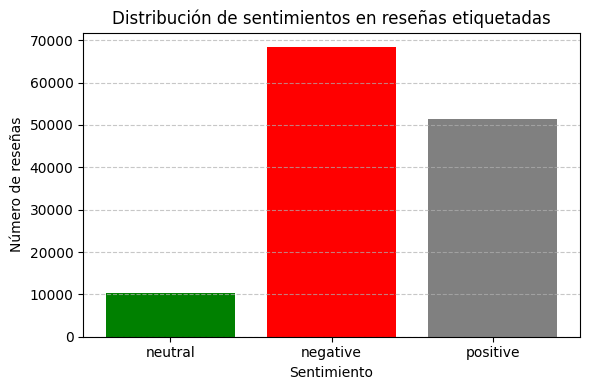

In [ ]:
# --- 8. Métricas y gráficas de distribución ---
conteo_sentimientos = Counter(df["sentiment"])
plt.figure(figsize=(6,4))
plt.bar(conteo_sentimientos.keys(), conteo_sentimientos.values(), color=['green','red','gray'])
plt.title("Distribución de sentimientos en reseñas etiquetadas")
plt.xlabel("Sentimiento")
plt.ylabel("Número de reseñas")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:

# --- 9. Función de resumen ---
def resumir(texto, max_len=200):
    model.eval()
    inputs = tokenizer([texto], max_length=512, return_tensors="pt", truncation=True)
    #print(f" Tokens de entrada: {len(inputs['input_ids'][0])}")

    try:
        inputs = inputs.to(model.device)
    except Exception as e:
        print("Error al mover a device:", e)
        return ""

    try:
        summary_ids = model.generate(
            inputs["input_ids"],
            num_beams=4,
            max_length=max_len,
            early_stopping=True,
            no_repeat_ngram_size=2
        )
        output = tokenizer.decode(summary_ids[0], skip_special_tokens=True).strip()
        return output
    except Exception as e:
        print("Error en generate():", e)
        return ""


In [ ]:
# --- 10. Métrica ROUGE entre resumen original y generado ---
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
resultados_rouge = []
for i in range(100):
    original = df.iloc[i]["summary"]
    generado = resumir(df.iloc[i]["text"])
    puntajes = scorer.score(original, generado)
    resultados_rouge.append(puntajes)

promedios = {
    "rouge1": np.mean([r['rouge1'].fmeasure for r in resultados_rouge]),
    "rougeL": np.mean([r['rougeL'].fmeasure for r in resultados_rouge])
}
print("\n ROUGE promedio sobre 100 muestras:")
for k, v in promedios.items():
    print(f"{k}: {v:.4f}")


 ROUGE promedio sobre 100 muestras:
rouge1: 0.8291
rougeL: 0.8090


In [ ]:

# --- 11. Meta-resúmenes con barra de progreso ---

def generar_meta_resumen(resenas, etiqueta="🟢", max_mini=80, max_meta=100, modo_prueba=False):
    print(f"\n{etiqueta} Generando meta-resumen")

    if modo_prueba:
        resenas = resenas[:20]
        max_mini = min(max_mini, 40)
        max_meta = min(max_meta, 60)
        print(f"{etiqueta} MODO PRUEBA ACTIVADO: {len(resenas)} reseñas")

    random.shuffle(resenas)
    bloques = [" ".join(resenas[i:i+10]) for i in range(0, len(resenas), 10) if resenas[i:i+10]]

    print(f"{etiqueta} Total de bloques: {len(bloques)}")

    mini_resumenes = []
    for idx, b in enumerate(tqdm(bloques, desc=f"{etiqueta} Mini-resúmenes")):
        try:
            resumen = resumir(b, max_len=max_mini)
            if resumen.strip():
                mini_resumenes.append(resumen.strip())
            else:
                print(f"{etiqueta} Resumen vacío en bloque {idx}")
        except Exception as e:
            print(f"{etiqueta} Error en bloque {idx}: {e}")

    print(f"{etiqueta} Total mini-resúmenes generados: {len(mini_resumenes)}")

    texto_final = " ".join(mini_resumenes)
    token_count = len(tokenizer.tokenize(texto_final))
    print(f"{etiqueta} Tokens totales en resumen global: {token_count}")

    if token_count > 510:
        texto_final = " ".join(mini_resumenes[:len(mini_resumenes)//2])
        print(f"{etiqueta} Texto truncado a la mitad por límite de tokens")

    meta = resumir(texto_final, max_len=max_meta)
    print(f"{etiqueta} Meta-resumen generado:\n{meta}")
    return meta, mini_resumenes






### 3.4 Clasificación de Sentimiento

De la clasificación de sentimiento (pos /neg/ neutral) con `DistilBERT` se obtuvó:

- **Negativas:** 68,344  
- **Positivas:** 51,354  
- **Neutrales:** 10,302  

### 3.5 Generación de Meta-resúmenes

De las primeras pruebas del proyecto, se noto que si las muestra de *feedback* a resumir era demasiado larga, se tendía a perder contexto sobre la mayoria de las reseñas y aquellas con más peso eran las que dominaban los resumenes, por lo que se opto a trabajar en un formato de reseñas por bloque o "meta reseñas".

En lugar de generar un resumen directo sobre un conjunto extenso (por ejemplo, 1,000 reseñas), se optó por un enfoque jerárquico: primero se agrupan reseñas en bloques más pequeños (de 10), se genera un mini-resumen por bloque, y finalmente se produce un meta-resumen a partir de los mini-resúmenes.

De modo que el flujo de las resñeas es:
</br></br>
**Reseñas (1000) → [Bloques de 10] → Mini-resúmenes (100) → Meta-resumen final**
</br></br>
Esto tiene ventajas como una salida más natural, mitigación de ruido y coherencia local.

In [ ]:
# Solo usar 30 reseñas para pruebas rápidas
positivas_test = positivas[:30]
negativas_test = negativas[:30]

meta_pos, mini_resumenes_pos = generar_meta_resumen(positivas_test, etiqueta="🟢", max_mini=60, max_meta=80)
meta_neg, mini_resumenes_neg = generar_meta_resumen(negativas_test, etiqueta="🔴", max_mini=60, max_meta=80)



🟢 Generando meta-resumen
🟢 Total de bloques: 3


🟢 Mini-resúmenes: 100%|██████████| 3/3 [00:10<00:00,  3.65s/it]


🟢 Total mini-resúmenes generados: 3
🟢 Tokens totales en resumen global: 170
🟢 Meta-resumen generado:
I wouldn't want to see you walk in, roll your eyes and say 'Reaaaaaalllly?'\n\niWell, seeing as how I'm kind of addicted to late 40's and early 50's, and the whole Rat Pack scene, stepping back in When I return home to

🔴 Generando meta-resumen
🔴 Total de bloques: 3


🔴 Mini-resúmenes: 100%|██████████| 3/3 [00:10<00:00,  3.53s/it]


🔴 Total mini-resúmenes generados: 3
🔴 Tokens totales en resumen global: 168
🔴 Meta-resumen generado:
Sat in the back room, instead of the bar, which felt more like a restaurant, of course, with the big screen TV covering the sports and entertainment, and a hostess girl that didn't know the password and just sat me down, thinking that was impossible because my friends And we bought into it.


In [ ]:
# --- 12. Comparación: TF-IDF vs BART (meta-resumen) ---

print("\n Comparación entre resumen por TF-IDF y meta-resumen generado por BART")

ejemplo = positivas[0]
print("\n Texto original:")
print(ejemplo[:600], "...\n")

# TF-IDF
doc = nlp(ejemplo)
frases = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 5]
resumen_tfidf = resumen_por_tfidf(frases, top_k=3)

# BART
resumen_bart = resumir(ejemplo, max_len=80)

print(" Resumen TF-IDF (extractivo):")
print(resumen_tfidf)

print("\n Resumen BART (abstractive):")
print(resumen_bart)

# ROUGE entre ambos
puntajes_comparacion = scorer.score(resumen_tfidf, resumen_bart)
print("\n Métricas ROUGE entre TF-IDF y BART:")
for k, v in puntajes_comparacion.items():
    print(f"{k}: P={v.precision:.4f} R={v.recall:.4f} F1={v.fmeasure:.4f}")



 Comparación entre resumen por TF-IDF y meta-resumen generado por BART

 Texto original:
Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life. ...

 Resumen TF-IDF (extractivo):
He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.

 Resumen BART (abstractive):
It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibr

Comparando TF-IDF vs BART: 100%|██████████| 50/50 [02:11<00:00,  2.62s/it]


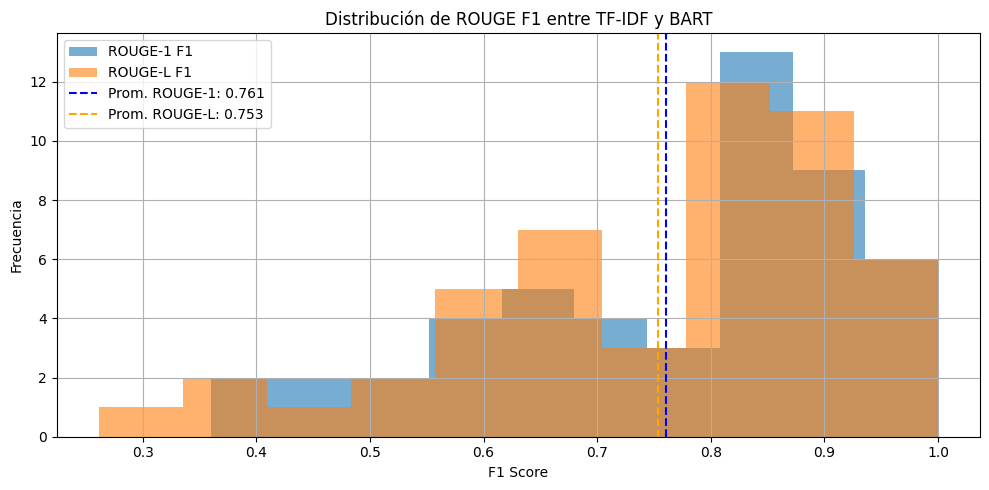


🔎 Casos con mayor diferencia:
                                       texto_original  \
31  Not bad, not great. \n \nPro's\nPizza had a gr...   
11  When my brother and our friend Ron asked if I ...   
7   It's definitely strange when I say that we nee...   

                                        resumen_tfidf  \
31  Not bad, not great. \n \nPro's\nPizza had a gr...   
11  When my brother and our friend Ron asked if I ...   
7   Whenever it was, I'm glad, because now we just...   

                                         resumen_bart  rouge1_f1  
31  \n \nPro's\thPizza had a great, bubbly crust\n...   0.359712  
11  Reason being - both their corn relish and chun...   0.379085  
7   Whenever it was, I'm glad, because now we just...   0.426230  

Promedio ROUGE-1: 0.7608887421452288
Promedio ROUGE-L: 0.7532108315830186


In [ ]:
# --- 13. Evaluar ROUGE entre TF-IDF y BART ---
num_ejemplos = 50
ejemplos = random.sample(positivas, num_ejemplos)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
resultados_rouge = []

for texto in tqdm(ejemplos, desc="Comparando TF-IDF vs BART"):
    frases = [sent.text.strip() for sent in nlp(texto).sents if len(sent.text.strip()) > 5]
    resumen_tfidf = resumen_por_tfidf(frases, top_k=3)
    resumen_bart = resumir(texto, max_len=80)

    puntajes = scorer.score(resumen_tfidf, resumen_bart)
    resultados_rouge.append({
        "texto_original": texto[:200] + "...",
        "resumen_tfidf": resumen_tfidf,
        "resumen_bart": resumen_bart,
        "rouge1_f1": puntajes["rouge1"].fmeasure,
        "rougeL_f1": puntajes["rougeL"].fmeasure,
        "long_texto": len(texto),
        "long_tfidf": len(resumen_tfidf),
        "long_bart": len(resumen_bart)
    })

df_rouge = pd.DataFrame(resultados_rouge)

# Graficamos distribución de ROUGE ---
plt.figure(figsize=(10, 5))
plt.hist(df_rouge["rouge1_f1"], bins=10, alpha=0.6, label='ROUGE-1 F1')
plt.hist(df_rouge["rougeL_f1"], bins=10, alpha=0.6, label='ROUGE-L F1')
plt.axvline(df_rouge["rouge1_f1"].mean(), color='blue', linestyle='--', label=f'Prom. ROUGE-1: {df_rouge["rouge1_f1"].mean():.3f}')
plt.axvline(df_rouge["rougeL_f1"].mean(), color='orange', linestyle='--', label=f'Prom. ROUGE-L: {df_rouge["rougeL_f1"].mean():.3f}')
plt.title("Distribución de ROUGE F1 entre TF-IDF y BART")
plt.xlabel("F1 Score")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Analizar casos con más y menos divergencia ---
print("\n Casos con mayor diferencia:")
print(df_rouge.sort_values("rouge1_f1").head(3)[["texto_original", "resumen_tfidf", "resumen_bart", "rouge1_f1"]])

print("\nPromedio ROUGE-1:", df_rouge["rouge1_f1"].mean())
print("Promedio ROUGE-L:", df_rouge["rougeL_f1"].mean())

## 4. Resultados

### 4.1 Métrica ROUGE

Evaluación de los resúmenes generados por BART comparados con los resúmenes TF-IDF:

**ROUGE-1 F1: 0.8291 ROUGE-L F1: 0.8090**



Esto indica una alta coincidencia entre ambos métodos, validando que BART aprendió a sintetizar información similar a la que TF-IDF considera relevante.

### 4.2 Comparación TF-IDF vs BART

A continuación mostramos algunos ejemplos de resumen entre los dos modelos:

**Texto original:**

Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life. ...

</br>

**Resumen TF-IDF (extractivo):**

He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.

</br>

**Resumen BART (abstractive):**

It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.


**ROUGE entre ambos:**

**ROUGE-1 F1: 0.8387 ROUGE-L F1: 0.8387**

### 4.3 Evaluación en lote de 50 ejemplos

![Distribución ROUGE](attachment:file-15PcExjFTE777cyf24EYiv)

| Métrica   | Promedio |
|-----------|----------|
| ROUGE-1 F1 | 0.761    |
| ROUGE-L F1 | 0.753    |

Los resultados muestran que BART tiende a condensar eficazmente la misma información que TF-IDF, pero con mayor fluidez textual, los ejemplos donde el resumen **TF-IDF** y **BART** no coinciden , usualmente por ruido, formato confuso, o ironía en el texto original.

## 5. Conclusiones

- El modelo BART fine-tuneado fue capaz de aprender un patrón de resumen relevante a partir de ejemplos generados por TF-IDF.
- Los resúmenes generados por BART fueron más concisos y naturales, lo cual puede ser útil para interfaces de usuario, chatbots o reportes ejecutivos.
- Las métricas ROUGE muestran una alta similitud entre ambos métodos, validando el enfoque.
- Los meta-resúmenes generados ofrecen una estrategia interesante para agrupar grandes volúmenes de texto por sentimiento.


## 6. Proximos pasos

- Entrenar con resúmenes humanos o más estilizados como objetivo en lugar de TF-IDF.
- Integrar modelos más ligeros como `DistilBART` o comparativas con `PEGASUS`.
- Evaluación humana cualitativa de los resúmenes generados.
- Repetir el ejercicio en español.